### Install dependencies

In [ ]:
!conda activate py39
!conda install --file ./requirements.txt
!conda install --file ./examples/requirements.txt


### Download GLUE dataset


In [ ]:
!python download_glue_data.py --data_dir glue_data --tasks all


### Variables


In [1]:
PATH_TO_DATA="glue_data"
MODEL_TYPE="bert"  # bert or roberta
MODEL_SIZE="base"  # base or large
DATASETS="CoLA SST-2 MRPC STS-B QQP MNLI QNLI RTE WNLI"
# CoLA  acceptability
# SST-2 sentiment
# MRPC  paraphrase
# STS-B sentence similarity FIXME: doesn't work
# QQP   paraphase
# MNLI  NLI
# QNLI  QA/NLI
# RTE   NLI FIXME: doesn't work
# WNLI  coreference/NLI
DATASET="MRPC"
N_GPU=2

### This is for fine-tuning and evaluating models as in the original BERT paper.


In [ ]:
!bash scripts/train.sh {PATH_TO_DATA} {MODEL_TYPE} {MODEL_SIZE} {DATASET} {N_GPU}


### This is for fine-tuning DeeBERT models.


In [ ]:
!bash scripts/train_highway.sh {PATH_TO_DATA} {MODEL_TYPE} {MODEL_SIZE} {DATASET} {N_GPU}


### This is for evaluating each exit layer for fine-tuned DeeBERT models.


In [ ]:
!bash scripts/eval_highway.sh {PATH_TO_DATA} {MODEL_TYPE} {MODEL_SIZE} {DATASET}


### This is for evaluating fine-tuned DeeBERT models, given a number of different early exit entropy thresholds.


In [ ]:
!bash scripts/eval_entropy.sh {PATH_TO_DATA} {MODEL_TYPE} {MODEL_SIZE} {DATASET}


### This is for reading `.npy` data in `plotting/`


plotting/saved_models/bert-base/MRPC/two_stage/
plotting/saved_models/bert-base/MRPC/two_stage/each_layer.npy
[0.81222707 0.81222707 0.81222707 0.81222707 0.82861401 0.84094488
 0.84751204 0.8427673  0.8576     0.85806452 0.86363636 0.88666667]
plotting/saved_models/bert-base/MRPC/two_stage/entropy_0.0.npy
[{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 408}
 {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 340}
 4.7705090045928955 1.0 0.8866666666666667]
plotting/saved_models/bert-base/MRPC/two_stage/entropy_0.1.npy
[{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 2, 11: 12, 12: 394}
 {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 2, 11: 12, 12: 326}
 4.668928861618042 0.9967320261437909 0.8866666666666667]
plotting/saved_models/bert-base/MRPC/two_stage/entropy_0.2.npy
[{1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 2, 8: 0, 9: 1, 10: 74, 11: 38, 12: 292}
 {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 2, 8: 0, 9: 1, 10: 73, 1

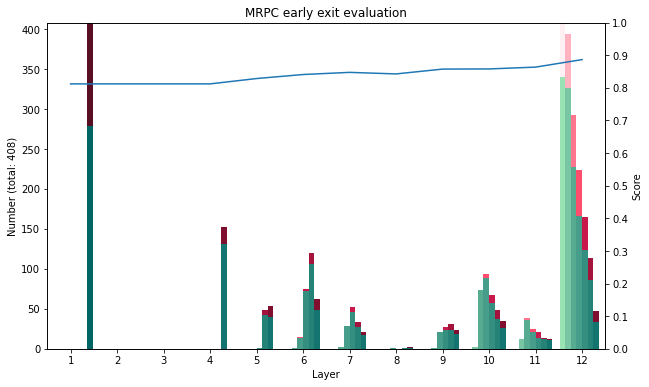

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import math

relative_path = "plotting/saved_models/"+MODEL_TYPE + \
    "-"+MODEL_SIZE+"/"+DATASET+"/two_stage/"
print(relative_path)


correct_colors = ['#99e2b4', '#78c6a3', '#56AB91', '#469D89',
                  '#358F80', '#248277', '#14746F', '#036666']
incorrect_colors = ['#FFF0F3', '#FFB3C1', '#FF758F', '#FF4D6D',
                    '#C9184A', '#A4133C', '#800F2F', '#590D22']


def plot(fname, data, cnt):
    if fname == 'each_layer.npy':
        x = np.arange(1, 13)
        ax2.plot(x, data)
        ax2.set_xlabel('Layer')
        ax2.set_ylabel('Score')
        ax2.xaxis.set_major_locator(plt.MultipleLocator(1))
        ax2.yaxis.set_major_locator(plt.MultipleLocator(0.1))
        ax2.set_ylim(bottom=0, top=1)
    else:
        total = list(data[0].values())
        correct = list(data[1].values())
        incorrect = [i - j for i, j in zip(total, correct)]
        y_lim = np.sum(total)
        x = np.arange(1, 13)
        width = 0.12
        bias = (cnt-4.5)*width
        ax1.bar(x+bias, correct, width, label='correct',
                color=correct_colors[(cnt-1) % len(correct_colors)])
        ax1.bar(x+bias, incorrect, width,
                bottom=correct, label='incorrect', color=incorrect_colors[(cnt-1) % len(incorrect_colors)])
        ax1.set_title(DATASET+' early exit evaluation')
        ax1.set_xlabel('Layer')
        ax1.set_ylabel('Number (total: {})'.format(y_lim))
        ax1.xaxis.set_major_locator(plt.MultipleLocator(1))
        ax1.set_xlim(left=0.5, right=12.5)
        ax1.set_ylim(bottom=0, top=y_lim)


for path, lists, frame in os.walk(relative_path):
    frame.sort()
    cnt = 0
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(1, 1, 1)
    ax2 = ax1.twinx()
    for fname in frame:
        print(path+fname)
        data = np.load(path+"/"+fname, allow_pickle=True)
        print(data)
        plot(fname, data, cnt)
        cnt += 1
    plt.show()
